In [1]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [2]:
train, info = tfds.load("malaria", split='train[:80%]', shuffle_files=True, as_supervised= True, with_info=True)
test, info = tfds.load("malaria", split='train[:20%]', shuffle_files=True, as_supervised= True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incomplete6J2DG4/malaria-train.tfrecord


Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [3]:
info.splits

{'train': <tfds.core.SplitInfo num_examples=27558>}

In [4]:
tr = []
tr_lbls = []
tst = [] 
tst_lbls = []

for img in train:
  tr.append(img[0])
  tr_lbls.append(img[1])

for img in test:
  tst.append(img[0])
  tst_lbls.append(img[1])


In [5]:
# tr = np.array(tr)
# tst = np.array(tst)
tr_lbls = np.array(tr_lbls)
tst_lbls = np.array(tst_lbls)

In [39]:
tr = [tf.image.resize_with_pad(img, 64, 64) for img in tr]
tst = [tf.image.resize_with_pad(img, 64, 64) for img in tst]
  

In [40]:
print(tr[0])
print(tr_lbls[:10])
print(type(tr))

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(64, 64, 3), dtype=float32)
[0 0 0 0 0 1 1 1 0 1]
<class 'list'>


tf.Tensor([64 64  3], shape=(3,), dtype=int32)
tf.Tensor([64 64  3], shape=(3,), dtype=int32)
tf.Tensor([64 64  3], shape=(3,), dtype=int32)
tf.Tensor([64 64  3], shape=(3,), dtype=int32)
tf.Tensor([64 64  3], shape=(3,), dtype=int32)


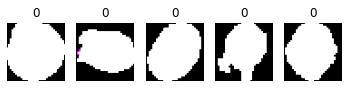

In [41]:
# Plot 5 samples with their corresponding label.
fig, ax = plt.subplots(1,5)
for i in range(5):

    # Readout an image and the corresponding label.
    img = tr[i]
    print(tf.shape(img))
    
    ax[i].imshow(img)
    ax[i].set_title(tr_lbls[i])
    ax[i].axis("off")



In [42]:
train_dataset_images = tf.data.Dataset.from_tensor_slices(tr) 
train_dataset_targets = tf.data.Dataset.from_tensor_slices(tr_lbls)
train_dataset_targets = train_dataset_targets.map(lambda t : tf.one_hot(t, 2)) 

# zip together input and labels
train_dataset = tf.data.Dataset.zip((train_dataset_images, train_dataset_targets))
train_dataset = train_dataset.batch(64)
train_dataset = train_dataset.shuffle(buffer_size=5000)
print(train_dataset)

# repeat for the test dataset
test_dataset_images = tf.data.Dataset.from_tensor_slices(tst)
test_dataset_targets = tf.data.Dataset.from_tensor_slices(tst_lbls)
test_dataset_targets = test_dataset_targets.map(lambda t : tf.one_hot(t, 2))

test_dataset = tf.data.Dataset.zip((test_dataset_images, test_dataset_targets))
test_dataset = test_dataset.batch(64)
test_dataset = test_dataset.shuffle(buffer_size=1000)
print(test_dataset)


<ShuffleDataset shapes: ((None, 64, 64, 3), (None, 2)), types: (tf.float32, tf.float32)>
<ShuffleDataset shapes: ((None, 64, 64, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [43]:
# Model

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the three layers.
        self.conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               input_shape=(32,32,3)
                                               )
        self.max_pool_1 = tf.keras.layers.MaxPool2D()
        self.conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                               )
        self.max_pool_2 = tf.keras.layers.MaxPool2D()

        self.conv_3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,
                                               activation=tf.keras.activations.relu,
                                                )
        self.max_pool_3 = tf.keras.layers.MaxPool2D()

        self.conv_4 = tf.keras.layers.Conv2D(filters=128, kernel_size=3, 
                                               activation=tf.keras.activations.relu,
                                                )
        self.max_pool_4 = tf.keras.layers.MaxPool2D()

        self.flatten = tf.keras.layers.Flatten()

        self.output_layer = tf.keras.layers.Dense(2,
                                                  activation=tf.keras.activations.softmax)

    def call(self, x):
        # Define the forward step.
        x = self.conv_1(x)
        x = self.max_pool_1(x)
        x = self.conv_2(x)
        x = self.max_pool_2(x)
        x = self.conv_3(x)
        x = self.max_pool_3(x)
        x = self.conv_4(x)
        x = self.max_pool_4(x)
        x = self.flatten(x)
        x = self.output_layer(x)
        return x

In [44]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  


In [45]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.00005
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
binary_crossentropy_loss = tf.keras.losses.BinaryCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.Adam(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_dataset, binary_crossentropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_dataset, binary_crossentropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_dataset.shuffle(buffer_size=128)
    test_dataset = test_dataset.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_dataset:
        train_loss = train_step(model, input, target, binary_crossentropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


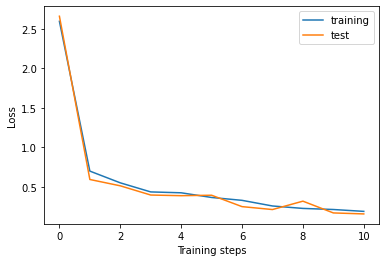

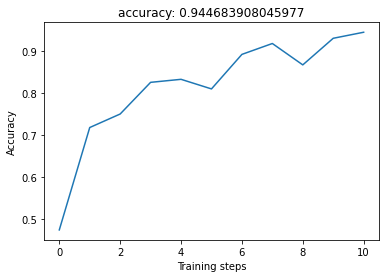

In [46]:
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.title('accuracy: '+ str(np.max(test_accuracies)))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()